## DS3 Self Driving Car Code

Imported Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import ops
import cv2
import os
import torchvision.transforms as transforms
from PIL import Image 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Get your directory 
current_dir = os.getcwd()
print(current_dir)

/home/k1mittal


### These are functions which displays files and gets the file names. 

In [3]:
def display_files(number_displayed, data):
    RGB_dataA_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB"))[:number_displayed]
    Seg_dataA_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg"))[:number_displayed]
    
    for i in range(len(RGB_dataA_files)):
        RGB_dataA_files[i] = cv2.imread(current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB/" + RGB_dataA_files[i])
        Seg_dataA_files[i] = cv2.imread(current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg/" + Seg_dataA_files[i], cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(len(RGB_dataA_files), 2, figsize=(10, 15))
    axes[0, 0].set(title = f"Original Image")
    axes[0, 1].set(title = f"Mask Image")
    for i in range(len(RGB_dataA_files)):
        axes[i][0].imshow(RGB_dataA_files[i])
        axes[i][1].imshow(Seg_dataA_files[i])

    plt.show()

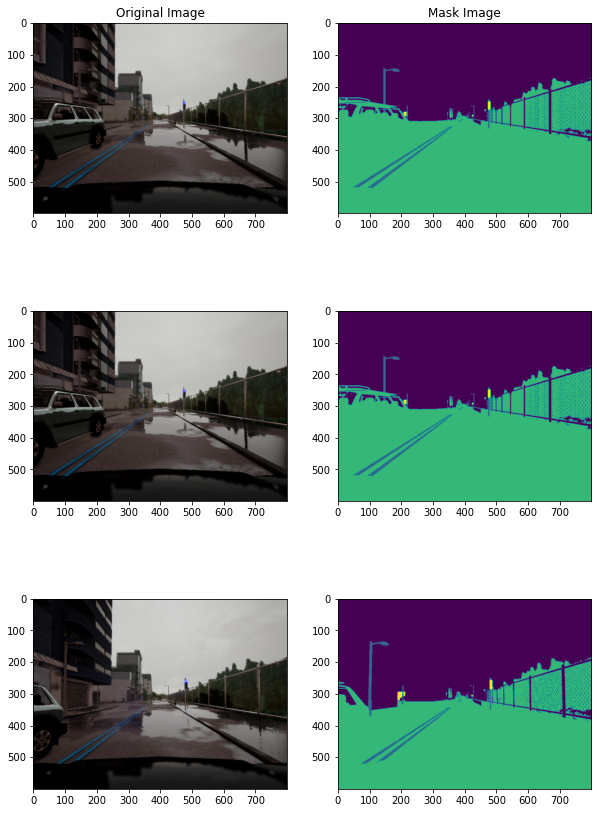

In [4]:
display_files(3, "dataA")

In [5]:
def store_data(data):
    RGB_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB"))
    Seg_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg"))
    for i in range(len(RGB_files)):
        RGB_files[i] = current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB/" + RGB_files[i]
    for i in range(len(Seg_files)):
        Seg_files[i] = current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg/" + Seg_files[i]

    return (RGB_files, Seg_files)

In [6]:
image_files = []
mask_files = []
image_files += store_data("dataA")[0]
image_files += store_data("dataB")[0]
image_files += store_data("dataC")[0]
image_files += store_data("dataD")[0]
image_files += store_data("dataE")[0]

mask_files += store_data("dataA")[1]
mask_files += store_data("dataB")[1]
mask_files += store_data("dataC")[1]
mask_files += store_data("dataD")[1]
mask_files += store_data("dataE")[1]

print(image_files[100] + "\n" + mask_files[100])

/home/k1mittal/archive-2/dataA/dataA/CameraRGB/02_02_000.png
/home/k1mittal/archive-2/dataA/dataA/CameraSeg/02_02_000.png


### Creating a custom Dataset and Creating a Dataloader

In [7]:
class CustomData(Dataset) : 
    def __init__(self, img_path , mask_path) : 
        self.img_path = img_path 
        self.mask_path = mask_path
        self.transform = transforms.Compose([
            transforms.Resize(size = (224 , 224)) , 
            ToTensor()
        ])
            
    
    def __len__(self) : 
        return len(self.img_path)
    
    
    def __getitem__(self , idx) : 
        image = Image.open(self.img_path[idx])
        tensor_image = self.transform(image)
        
        mask = Image.open(self.mask_path[idx])
        tensor_mask = self.transform(mask)
        
        
        return tensor_image/255, tensor_mask

In [8]:
# Split the Data into test, train, images, and masks
train_images_dir , test_images_dir , train_masks_dir , test_masks_dir = train_test_split(image_files , mask_files , test_size = 0.01)

In [9]:
# Create CustomData for training and test
train_set = CustomData(train_images_dir , train_masks_dir)
test_set = CustomData(test_images_dir , test_masks_dir)

In [10]:
# print(train_set.__getitem__(1000))

In [11]:
# Creating a training and testing dataloader
train_dataloader = DataLoader(
    dataset = train_set , 
    batch_size = 4, 
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_set , 
    batch_size = 4, 
    shuffle = False
)

In [12]:
trainimage_sample , trainmask_sample = next(iter(train_dataloader))
# print(trainmask_sample[0])

### This is plotting the images from the dataloaders, which has random images. 

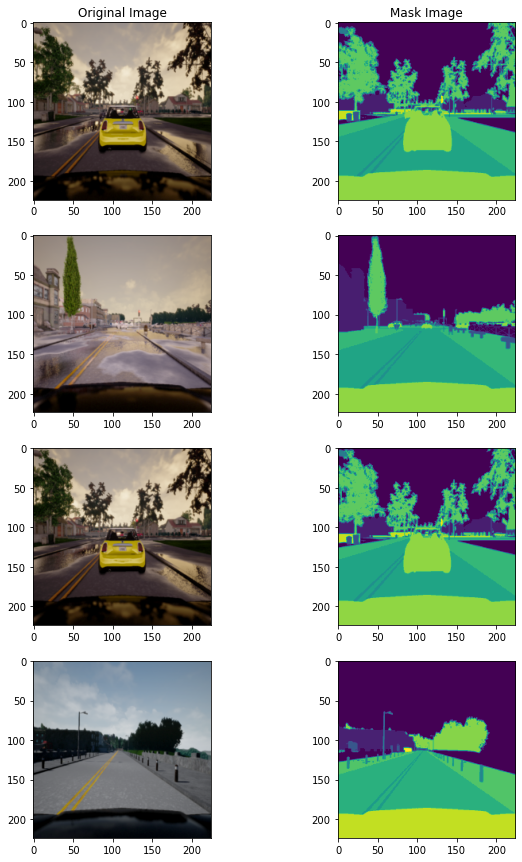

In [13]:
amount_of_images_displayed = 4
fig, axes = plt.subplots(amount_of_images_displayed, 2, figsize=(10, 15))
axes[0, 0].set(title = f"Original Image")
axes[0, 1].set(title = f"Mask Image")
for i in range(amount_of_images_displayed):
    original = (trainimage_sample[i]*255).numpy()
    original = np.transpose(original, (1,2,0))
    axes[i, 0].imshow(original)
      
    mask = trainmask_sample[i].numpy()
    mask = np.transpose(mask, (1,2,0))
    axes[i, 1].imshow(mask[:,:,0])

### Sanity Check!

In [14]:
def Intersection_Over_Union(target_tensor, prediction_tensor):
    target = target_tensor[0].numpy()
    prediction = prediction_tensor[0].numpy()
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print('IOU : ', iou_score)

In [15]:
input_shape = (224, 224, 3)

In [16]:
# VGG16_weight = current_dir + "/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

# # segmentation model definer

# def create_segmentation_model(input_shape):
#     base_model = vgg16.VGG16(include_top=False, input_shape=input_shape, weights=VGG16_weight)
    
#     #uncomment this if want to disable back propagation
#     # for layer in base_model.layers:
#     #     layer.trainable = False
    
#     #encoder
#     encoder_output = base_model.output
    
#     #decoder
#     '''first upsample'''
#     x = UpSampling2D(size=(2, 2))(encoder_output)
#     x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
#     skip_connection_layer = base_model.get_layer('block5_conv3').output
#     x = concatenate([x, skip_connection_layer])
    
#     '''Second upsample'''
    
#     x = UpSampling2D(size=(2, 2))(x)
#     x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
#     skip_connection_layer = base_model.get_layer('block4_conv3').output
#     x = concatenate([x, skip_connection_layer])
    
#     '''third upsample'''
#     x = UpSampling2D(size=(2, 2))(x)
#     x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
#     skip_connection_layer = base_model.get_layer('block3_conv3').output
#     x = concatenate([x, skip_connection_layer])
    
#     '''fourth upsample'''
    
#     x = UpSampling2D(size=(2, 2))(x)
#     x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
#     skip_connection_layer = base_model.get_layer('block2_conv2').output
#     x = concatenate([x, skip_connection_layer])
    
#     '''fifth upsample'''
#     x = UpSampling2D(size=(2, 2))(x)
#     x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
#     skip_connection_layer = base_model.get_layer('block1_conv2').output
#     x = concatenate([x, skip_connection_layer])
    
    
#     #output layer
#     output = Conv2D(filters=13, kernel_size=(1, 1), activation='softmax', padding='same')(x)
#     model = Model(inputs=base_model.input, outputs=output)
#     return model


# def one_hot_encode_masks(masks, num_classes=13):
#     # Assume masks are single-channel with class indices
#     masks = tf.cast(masks, tf.int32)
#     one_hot_masks = tf.one_hot(masks, depth=num_classes)
#     # Remove the channel dimension added by tf.one_hot
#     if one_hot_masks.shape[-2] == 1:
#         one_hot_masks = tf.squeeze(one_hot_masks, axis=-2)  # Squeeze only if the second last dimension is 1
#     return one_hot_masks

# def load_and_preprocess_image(image_path, mask_path):
#     # Load image
#     image = load_img(image_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = image / 255.0  # Normalize image

#     # Load mask and convert it to a single-channel class index format
#     mask = load_img(mask_path, color_mode='grayscale', target_size=(224, 224))  # Ensure this matches your mask format
#     mask = img_to_array(mask)
#     mask = mask.reshape((224, 224))  # Ensure mask is single-channel
#     mask = one_hot_encode_masks(mask, num_classes=13)

#     return image, mask


# # Generator function to yield preprocessed images and masks
# def train_image_mask_generator():
#     for img_path, mask_path in zip(train_images_dir, train_masks_dir):
#         image, mask = load_and_preprocess_image(img_path, mask_path)
#         yield image, mask

# def valid_image_mask_generator():
#     for img_path, mask_path in zip(test_images_dir, test_masks_dir):
#         image, mask = load_and_preprocess_image(img_path, mask_path)
#         yield image, mask
        
# # Create TensorFlow dataset from generator
# ';'
# train_dataset = tf.data.Dataset.from_generator(train_image_mask_generator,
#                                          output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
#                                                           tf.TensorSpec(shape=(224, 224, 13), dtype=tf.float32)))
# val_dataset = tf.data.Dataset.from_generator(valid_image_mask_generator,
#                                          output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
#                                                           tf.TensorSpec(shape=(224, 224, 13), dtype=tf.float32)))
# batch_size = 40
# train_dataset = train_dataset.batch(batch_size)
# print(train_dataset)
# print(val_dataset)


# model = create_segmentation_model(input_shape=(224, 224, 3))  # Assuming n classes including background
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='loss', patience=10)

# # checkpoint_filepath = '/User/tmp/checkpoint/epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5'
# # model_checkpoint_callback = ModelCheckpoint(
# #     filepath=checkpoint_filepath,
# #     save_weights_only=True,
# #     monitor='val_loss',
# #     mode='min',
# #     save_best_only=False) # Save the model after every epoch

# model.summary()



# # Set up the ModelCheckpoint callback




# history = model.fit(
#     train_dataset,
#     # validation_data=val_dataset,
#     epochs=10, 
#     steps_per_epoch=10,
# #     verbose=1,
#     callbacks=[early_stopping]
# )


# model.save('finished-test2.keras')